# Comparing FIRST and MIST
## Subcortical segmentations: volume CoV within/between scanners

In [1]:
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

import glob
import re

sns.set_theme()
sns.set_context("talk")

In [2]:
# some useful dictonaries and lists
vendor_dict = {"TRI": "Siemens", "PRI": "Siemens", "ING": "Philips", "ACH": "Philips", "GEM": "GE"}

scanner_dict = {"NOT1ACH": "Philips Achieva",
                "NOT2ING": "Philips Ingenia", 
                "NOT3GEM": "GE MR750", 
                "OXF1PRI": "Siemens Prisma 32",
                "OXF2PRI": "Siemens Prisma 64",
                "OXF3TRI": "Siemens Trio"}

scanner_code_dict = {"NOT1ACH": "Ach",
                        "NOT2ING": "Ing", 
                        "NOT3GEM": "750", 
                        "OXF1PRI": "Pri32",
                        "OXF2PRI": "Pri64",
                        "OXF3TRI": "Trio"}

basic_info_hdrs = ['session', 'scanner_name', 'vendor', 'scanner_code', 
             'scanner_type', 'scanner_typeloc', 'scan_session_num', 'scan_session', 'subject']

info_hdrs = basic_info_hdrs


In [3]:
def get_measure_type(measure_names, IDP=True):
    measure_type = []
    if IDP == True:
        for l in measure_names:
            if 'dMRI_TBSS' in l:
                measure_type = measure_type + [re.search('dMRI_(.*)_[0-9]+', l).group(1).replace('TBSS', 'dMRI ROI')]
            elif 'dMRI_xtract' in l:
                measure_type = measure_type + [re.search('dMRI_(.*)_[0-9]+', l).group(1).replace('xtract', 'dMRI tract')]
            elif 'T1_SIENAX' in l:
                measure_type = measure_type + ['FSL Tissue volumes']
            elif 'T1_GM_parcellation' in l:
                measure_type = measure_type + ['FSL GM volumes']
            elif 'T1_FIRST' in l:
                measure_type = measure_type + ['FSL Subcortical volumes']
            elif 'freesurfer' in l:
                if 'aseg' in l:
                    measure_type = measure_type + ['FreeSurfer Subcortical volumes']
                elif 'DK' in l:
                    if 'SurfArea' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical surface area (DK)']
                    elif 'GrayVol' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical volume (DK)'] 
                    elif 'ThickAvg' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical thickness (DK)']
                    elif 'MeanCurv' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical curvature (DK)']
                elif 'a2009s' in l:
                    if 'SurfArea' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical surface area (Destrieux)']
                    elif 'GrayVol' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical volume (Destrieux)'] 
                    elif 'ThickAvg' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical thickness (Destrieux)']
                    elif 'MeanCurv' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical curvature (Destrieux)']                    
            elif 'T2_FLAIR' in l:
                measure_type = measure_type + ['WM hyperintensities']
            elif 'SWI_T2star' in l:
                measure_type = measure_type + ['SWI T2* subcortex']    
            elif 'rfMRI_d25' in l:
                if 'NodeAmplitude' in l:
                    measure_type = measure_type + ['rfMRI d=25 node amplitudes']
                elif 'corr' in l:
                    measure_type = measure_type + ['rfMRI d=25 connectivities']
            elif 'rfMRI_d100' in l:
                if 'NodeAmplitude' in l:
                    measure_type = measure_type + ['rfMRI d=100 node amplitudes']
                elif 'corr' in l:
                    measure_type = measure_type + ['rfMRI d=100 connectivities']   
            else:
                measure_type = measure_type + ["other"]
    elif IDP == False:
        for l in measure_names:
            if 'dMRI' in l:        
                measure_type = measure_type + ['dMRI']
            elif 'T1w' in l:
                measure_type = measure_type + ['T1'] 
            elif 'T2' in l:
                measure_type = measure_type + ['T2']
            elif 'SWI' in l:
                measure_type = measure_type + ['SWI'] 
            elif 'fmri' in l:
                measure_type = measure_type + ['fMRI']
            elif 'rfMRI' in l:
                measure_type = measure_type + ['fMRI']
                
    measure_type = [l.replace('_', ' ') for l in measure_type]
    measure_type = [l.replace('v1', ' ') for l in measure_type]
    return measure_type

## Build main dataframe

In [4]:
studydir='/Users/shaunwarrington/OneDrive - The University of Nottingham (1)/Deliverables/Papers/NHarmony'
fig_out = f'{studydir}/pyfigs'

# Load IDP headers
hdrs = np.loadtxt(f'{studydir}/data/headers.txt', 'str')
hdrs = np.concatenate([['session'], hdrs])
hdrs = [x for x in hdrs if 'mist' not in x] # not using MIST

# Load subject-wise IDPs
idp_files = glob.glob(f'{studydir}/data/IDPs/*[!denoise].txt')
df = [pd.read_csv(f, sep=" ", index_col=None, header=None) for f in idp_files]
df = pd.concat(df, ignore_index=True)

df.columns = hdrs
df = df[df.columns.drop(list(df.filter(regex='tfMRI')))] # drop task-fMRI IDPs

print(f'{df.shape[0]} sessions')
print('The raw measures:')
df.head(5)

99 sessions
The raw measures:


,session,1_l_align_to_std_diff,1_nl_align_to_std_diff,1_nl_align_to_std_warp,1_inverse_SNR,1_inverse_CNR,2_FLAIR_align_to_T1,MRI_align_to_T1,WI_align_to_T1,fMRI_align_to_T1,...,T1_GM_parcellation_L_VIIIb_Cerebellum_vol,T1_GM_parcellation_Vermis_VIIIb_Cerebellum_vol,T1_GM_parcellation_R_VIIIb_Cerebellum_vol,T1_GM_parcellation_L_IX_Cerebellum_vol,T1_GM_parcellation_Vermis_IX_Cerebellum_vol,T1_GM_parcellation_R_IX_Cerebellum_vol,T1_GM_parcellation_L_X_Cerebellum_vol,T1_GM_parcellation_Vermis_X_Cerebellum_vol,T1_GM_parcellation_R_X_Cerebellum_vol,T2_FLAIR_WMH_volume
0,03997_NOT2ING001,0.709639,0.565298,0.068010,0.023000,0.048365,0.417115,0.817849,0.398544,0.896350,...,2109.992313,329.589582,2049.580686,1162.600140,208.419435,1462.600181,578.780475,222.489944,442.430170,1293
1,14229_NOT2ING001,0.709498,0.558609,0.074845,0.023515,0.050278,0.332084,0.655481,0.396900,0.954145,...,2143.709358,353.850084,2574.299187,1158.141840,299.850408,1511.128623,575.468728,228.350319,631.039500,2118
2,10975_OXF1PRI001,0.671640,0.532363,0.060674,0.014329,0.029774,0.506442,0.606848,0.408396,0.862284,...,2109.548870,282.620293,2201.957280,1493.439980,277.000116,1541.828000,463.729077,230.000078,399.809908,89
3,13192_OXF2PRI001,0.751898,0.578664,0.066386,0.014678,0.031013,0.467204,0.739697,0.509247,0.966793,...,2340.322330,324.540300,1955.638035,1420.989965,309.450327,1752.868617,464.880968,175.439902,432.559840,594
4,03286_OXF2PRI001,0.779914,0.612624,0.075811,0.015209,0.034127,0.489486,0.624702,0.491941,0.867948,...,2426.239281,318.269952,2279.822940,1753.326639,419.030611,1997.429920,563.281340,239.979695,533.270100,4638


#### Get the header descriptions

In [5]:
hdr_descriptions = pd.read_csv(f'{studydir}/data/hdr_descriptions.txt', sep="\r\t", names=['desc'])
hdr_descriptions["hdr"] = np.loadtxt(f'{studydir}/data/headers.txt', 'str')
                                     
hdr_descriptions = hdr_descriptions[hdr_descriptions["hdr"].str.contains("tfMRI")==False]
hdr_descriptions = hdr_descriptions[hdr_descriptions["hdr"].str.contains("mist")==False]

def hdr_desc(hdr):
    try:
        desc = hdr_descriptions.loc[hdr_descriptions.hdr == hdr, 'desc'].values[0]
    except:
        desc = hdr
    return desc


/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38599/1054213702.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  hdr_descriptions = pd.read_csv(f'{studydir}/data/hdr_descriptions.txt', sep="\r\t", names=['desc'])


#### Add session info columns

In [6]:
sublist = [t.split('_')[0] for t in df.session.values]
scan_session = [t.split('_')[1] for t in df.session.values]
scan_session_num = [t[-3:] for t in scan_session]
scanner_typeloc = [t.split('00')[0] for t in scan_session]
scanner_type = [t[-3:] for t in scanner_typeloc]

df.insert(1, 'subject', sublist)
df.insert(1, 'scan_session', scan_session)
df.insert(1, 'scan_session_num', scan_session_num)
df.insert(1, 'scanner_typeloc', scanner_typeloc)
df.insert(1, 'scanner_type', scanner_type)
df.insert(1, 'vendor', df['scanner_type'].map(vendor_dict))
df.insert(1, 'scanner_name', df['scanner_typeloc'].map(scanner_dict))
df.insert(1, 'scanner_code', df['scanner_typeloc'].map(scanner_code_dict))

df.sort_values('session', inplace=True, ignore_index=True)
df.columns = df.columns.str.strip()

# remove fMRI opts sessions
df_fmriopts = df.loc[(df['scan_session_num'] == '002') & 
                     (df['scanner_type'].isin(['GEM', 'ING']))]
df_fmriopts_idx = df_fmriopts.index.values # indices to remove from main df
df.drop(index=(df_fmriopts_idx), inplace=True) # remove from main df


### Load in MIST values

In [7]:
# T1
mistdf = pd.read_csv(f"{studydir}/data/mist_T1_vols", sep=" ", index_col=None)
mistdf.rename(columns=lambda s: s.replace("mist", "mist1"), inplace=True)
# mistdf.drop('session', axis=1, inplace=True)
# mistdf.reset_index(level=0, inplace=True)
mistdf = mistdf.rename(columns={'index': 'session'})

# T1+T2
temp = pd.read_csv(f"{studydir}/data/mist_vols", sep=" ", index_col=None)
temp.rename(columns=lambda s: s.replace("mist", "mist2"), inplace=True)
# temp.drop('session', axis=1, inplace=True)
# temp.reset_index(level=0, inplace=True)
temp = temp.rename(columns={'index': 'session'})

mistdf = pd.merge(mistdf, temp, on="session", how="left")

# T1+T2+FA
temp = pd.read_csv(f"{studydir}/data/mist_FA_vols", sep=" ", index_col=None)
temp.rename(columns=lambda s: s.replace("mist", "mist3"), inplace=True)
# temp.drop('session', axis=1, inplace=True)
# temp.reset_index(level=0, inplace=True)
temp = temp.rename(columns={'index': 'session'})

mistdf = pd.merge(mistdf, temp, on="session", how="left")


In [8]:
# # T1+T2
# mistdf = pd.read_csv(f"{studydir}/data/mist_vols", sep=" ", index_col=None)
# mistdf.rename(columns=lambda s: s.replace("mist", "mist2"), inplace=True)
# # mistdf.drop('session', axis=1, inplace=True)
# # mistdf.reset_index(level=0, inplace=True)
# mistdf = mistdf.rename(columns={'index': 'session'})

# # T1+T2+FA
# temp = pd.read_csv(f"{studydir}/data/mist_FA_vols", sep=" ", index_col=None)
# temp.rename(columns=lambda s: s.replace("mist", "mist3"), inplace=True)
# # temp.drop('session', axis=1, inplace=True)
# # temp.reset_index(level=0, inplace=True)
# temp = temp.rename(columns={'index': 'session'})

# mistdf = pd.merge(mistdf, temp, on="session", how="left")


#### Useful main data (df) lists

In [9]:
df.sort_values('session', inplace=True, ignore_index=True)

# subject, vendor and scanner lists
sub_list = df.subject.unique()
ven_list = df.vendor.unique()
scanner_typeloc_list = df.scanner_typeloc.unique()
scanner_type_list = df.scanner_type.unique()

reptlist = [["13192", "OXF1PRI"],
            ["14229", "OXF2PRI"],
            ["14230", "OXF3TRI"],
            ["14482", "NOT1ACH"]]

## IDP-wise CoV in FIRST and MIST

In [10]:
def get_stats(df):
    mn = df.mean(axis=0).abs()
    std = df.std(axis=0).abs()
    med = df.median(axis=0).abs()
    mad = df.mad(axis=0)
    mad_med = mad/med
    cv = std/mn
    return mn, med, mad, cv, mad_med

def get_null_corr(figobj, nsamp1=10, nsamp2=6, niter=1000):
    nullcorr = np.zeros((niter,))
    for i in range(0, niter):
        nullcorr[i] = sc.stats.spearmanr(np.random.choice(range(nsamp1), nsamp1, replace=False), 
                           np.random.choice(range(nsamp1), nsamp1, replace=False), axis=1)[0]
        
    null_iqr = np.percentile(nullcorr, [25, 75])
    
    if hasattr(figobj, 'get_xlim'):
        xlims = figobj.get_xlim()[0], figobj.get_xlim()[1]
        ylims = figobj.get_ylim()[0], figobj.get_ylim()[1]
        figobj.fill_between([xlims[0]-1, xlims[1]+1], null_iqr[0], null_iqr[1], color='red', alpha=0.2)
        figobj.set_xlim(xlims[0], xlims[1])
        figobj.set_ylim(0, ylims[1])
    else:
        ylims = figobj.axes[0][0].get_ylim()[0], figobj.axes[0][0].get_ylim()[1]
        
        for ax in figobj.axes[0]:
            xlims = ax.get_xlim()[0], ax.get_xlim()[1]
            ax.fill_between([xlims[0]-1, xlims[1]+1], null_iqr[0], null_iqr[1], color='red', alpha=0.2)
            ax.set_xlim(xlims[0], xlims[1])
            
        g.set(ylim=(ylims[0], ylims[1]))


In [11]:
# mist includes:
# Putamen
# Globus pallidus
# Caudate nucleus (including nucleus accumbens)
# Thalamus


# get FIRST IDPs
first_hdrs = ['T1_FIRST_left_thalamus', 'T1_FIRST_right_thalamus',
              'T1_FIRST_left_pallidum', 'T1_FIRST_right_pallidum',
              'T1_FIRST_left_putamen', 'T1_FIRST_right_putamen',
              'T1_FIRST_left_hippocampus', 'T1_FIRST_right_hippocampus',
              'T1_FIRST_left_amygdala', 'T1_FIRST_right_amygdala',
              'T1_FIRST_left_caudate', 'T1_FIRST_right_caudate',
              'T1_FIRST_left_accumbens', 'T1_FIRST_right_accumbens'
             ]


mist_hdrs = ['mist_left_thalamus', 'mist_right_thalamus',
             'mist_left_pallidum', 'mist_right_pallidum',
             'mist_left_putamen','mist_right_putamen',
             'mist_left_hippocampus', 'mist_right_hippocampus',
             'mist_left_amygdala', 'mist_right_amygdala',
             'mist_left_caudate_accumbens', 'mist_right_caudate_accumbens'
#              ,'mist_left_red_nucleus', 'mist_right_red_nucleus', 
#               'mist_left_substantia_nigra','mist_right_substantia_nigra',
#              'mist_left_subthalamic_nucleus', 'mist_right_subthalamic_nucleus'
             ]

mist1_hdrs = [h.replace('mist', 'mist1') for h in mist_hdrs]
mist2_hdrs = [h.replace('mist', 'mist2') for h in mist_hdrs]
mist3_hdrs = [h.replace('mist', 'mist3') for h in mist_hdrs]


# first_idps = [i for i in hdrs if 'FIRST' in i]

# sum FIRST caudate and accumbens to match MIST
seg_df = df[basic_info_hdrs + first_hdrs].copy()
seg_df['T1_FIRST_left_caudate+accum'] = seg_df['T1_FIRST_left_caudate'] + seg_df['T1_FIRST_left_accumbens']
seg_df['T1_FIRST_right_caudate+accum'] = seg_df['T1_FIRST_right_caudate'] + seg_df['T1_FIRST_right_accumbens']

first_hdrs.append('T1_FIRST_left_caudate+accum')
first_hdrs.append('T1_FIRST_right_caudate+accum')
for l in ['T1_FIRST_left_caudate', 'T1_FIRST_right_caudate', 'T1_FIRST_left_accumbens', 'T1_FIRST_right_accumbens']:
    seg_df.drop(l, axis=1, inplace=True)
    first_hdrs.remove(l)

idp_hdrs = first_hdrs + mist1_hdrs + mist2_hdrs + mist3_hdrs
# idp_hdrs = first_hdrs + mist2_hdrs + mist3_hdrs


seg_df = pd.merge(seg_df, mistdf, on="session", how="left")


In [12]:
# get CoV for FIRST IDPs within and between scanners
seg_cov = pd.DataFrame()

# within-scanner CoV
for sub, sca in zip(["13192", "14229", "14230", "14482"], ["OXF1PRI", "OXF2PRI", "OXF3TRI", "NOT1ACH"]):
    mn, med, mad, cv, mad_med = get_stats(seg_df[(seg_df.subject == sub) & 
                                                   (seg_df.scanner_typeloc == sca)][idp_hdrs])
    measure_type = get_measure_type(cv.index)
    tempdf = pd.DataFrame({"IDP": cv.index, "value": cv, 'subject': sub, 'scanners': 'within\nscanner'})
    seg_cov = pd.concat((seg_cov, tempdf))
    
# between-scanner CoV
for sub in ["13192", "14229", "14230", "14482"]:
    mn, med, mad, cv, mad_med = get_stats(seg_df[(seg_df.subject == sub) & 
                                                   (seg_df.scan_session_num == '001')][idp_hdrs])
    measure_type = get_measure_type(cv.index)
    tempdf = pd.DataFrame({"IDP": cv.index, "value": cv, 'subject': sub, 'scanners': 'between\nscanner'})
    seg_cov = pd.concat((seg_cov, tempdf))
    
# combine left and right - just remove _left and _right from IDP names
seg_cov['IDP'] = seg_cov['IDP'].str.replace('T1_', '')
seg_cov['IDP'] = seg_cov['IDP'].str.replace('left_', '')
seg_cov['IDP'] = seg_cov['IDP'].str.replace('right_', '')
seg_cov['IDP'] = seg_cov['IDP'].str.replace('_', ' ')
seg_cov['IDP'] = seg_cov['IDP'].str.title()
seg_cov['IDP'] = seg_cov['IDP'].str.replace('First', 'FIRST')
seg_cov['IDP'] = seg_cov['IDP'].str.replace('Mist', 'MIST')

# add a method column denoting whether FIRST or MIST
seg_cov['Method'] = seg_cov['IDP']
seg_cov.loc[seg_cov['Method'].str.contains('FIRST'), 'Method'] = 'Unimodal (FIRST: T1)'
seg_cov.loc[seg_cov['Method'].str.contains('MIST1'), 'Method'] = 'Unimodal (MIST: T1)'
seg_cov.loc[seg_cov['Method'].str.contains('MIST2'), 'Method'] = 'Multimodal (MIST: T1, T2)'
seg_cov.loc[seg_cov['Method'].str.contains('MIST3'), 'Method'] = 'Multimodal (MIST: T1, T2, FA)'


/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38599/478565759.py:5: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = df.mad(axis=0)
/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38599/478565759.py:5: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = df.mad(axis=0)
/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38599/478565759.py:5: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = df.mad(axis=0)
/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38599/478565759.py:5: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df

## IDP-wise subject ranking

In [14]:
corrdf = []
for j, h in enumerate(idp_hdrs):
    arr = np.zeros((len(sub_list), len(scanner_typeloc_list)))
    for i, sca in enumerate(scanner_typeloc_list):
        arr[:, i] = seg_df[(seg_df.scan_session_num == '001') & (seg_df.scanner_typeloc == sca)][h]

    corr = sc.stats.spearmanr(arr, axis=0, nan_policy='omit')[0]
    corr = corr[np.triu_indices_from(corr, k=1)]
    
    corrdf.append(np.mean(corr))
    
corrdf = pd.DataFrame({'IDP':idp_hdrs, 'value':corrdf})
measure_type = get_measure_type(corrdf.IDP)
corrdf['IDP_type'] = measure_type
corrdf['scanners'] = 'All scanners'

# Siemens only
corrdf_sie = []
siemens_list = ['OXF1PRI', 'OXF2PRI', 'OXF3TRI']
for j, h in enumerate(idp_hdrs):
    arr = np.zeros((len(sub_list), len(siemens_list)))
    for i, sca in enumerate(siemens_list):
        arr[:, i] = seg_df[(seg_df.scan_session_num == '001') & (seg_df.vendor == 'Siemens') & (seg_df.scanner_typeloc == sca)][h]

    corr = sc.stats.spearmanr(arr, axis=0, nan_policy='omit')[0]
    corr = corr[np.triu_indices_from(corr, k=1)]
    
    corrdf_sie.append(np.mean(corr))
    
corrdf_sie = pd.DataFrame({'IDP':idp_hdrs, 'value':corrdf_sie})
measure_type = get_measure_type(corrdf_sie.IDP)
corrdf_sie['IDP_type'] = measure_type
corrdf_sie['scanners'] = 'Siemens only'

# combine dataframes
# IDP-category-wise box plots
plotdf = pd.concat((corrdf, corrdf_sie))

# combine left and right - just remove _left and _right from IDP names
plotdf['IDP'] = plotdf['IDP'].str.replace('T1_', '')
plotdf['IDP'] = plotdf['IDP'].str.replace('left_', '')
plotdf['IDP'] = plotdf['IDP'].str.replace('right_', '')
plotdf['IDP'] = plotdf['IDP'].str.replace('_', ' ')
plotdf['IDP'] = plotdf['IDP'].str.title()
plotdf['IDP'] = plotdf['IDP'].str.replace('First', 'FIRST')
plotdf['IDP'] = plotdf['IDP'].str.replace('Mist', 'MIST')

# add a method column denoting whether FIRST or MIST
plotdf['Method'] = plotdf['IDP']
plotdf.loc[plotdf['Method'].str.contains('FIRST'), 'Method'] = 'Unimodal (FIRST: T1)'
plotdf.loc[plotdf['Method'].str.contains('MIST1'), 'Method'] = 'Unimodal (MIST: T1)'
plotdf.loc[plotdf['Method'].str.contains('MIST2'), 'Method'] = 'Multimodal (MIST: T1, T2)'
plotdf.loc[plotdf['Method'].str.contains('MIST3'), 'Method'] = 'Multimodal (MIST: T1, T2, FA)'



## plot

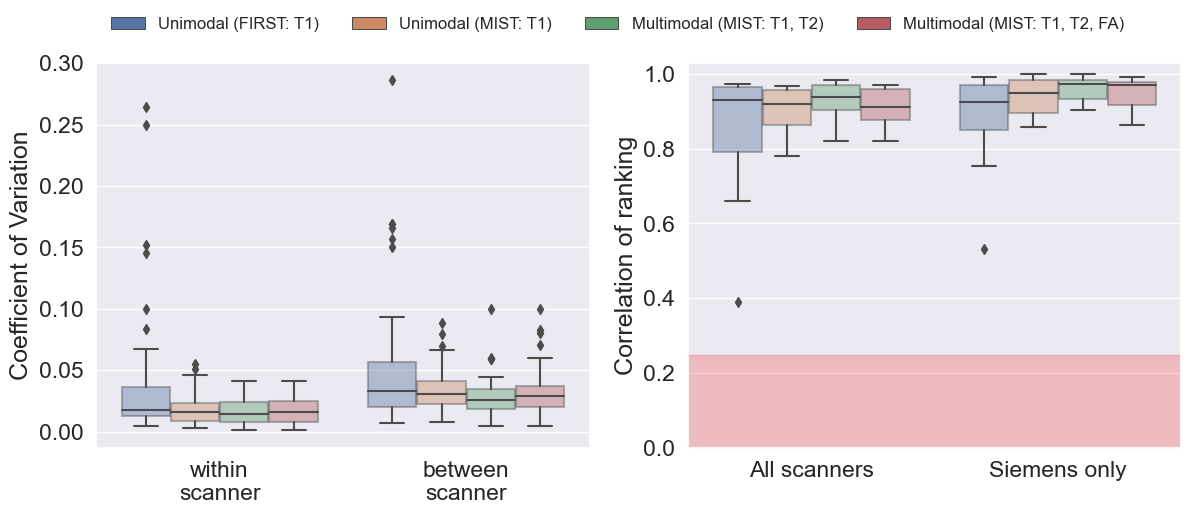

In [29]:
sns.set(font_scale = 1.5)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CoV
g = sns.boxplot(data=seg_cov, x='scanners', y='value', hue='Method', 
                boxprops={'alpha': 0.4}, palette="deep", ax=axes[0])
axes[0].set_ylabel('Coefficient of Variation');
axes[0].set_xlabel('');
# axes[0].legend([], [], frameon=False);
# axes[0].legend(loc='upper left', fontsize=14, frameon=False);
axes[0].legend(loc='center left', frameon=False, fontsize=12, bbox_to_anchor=(0, 1.1), ncol=4)

# CorrRanking
g = sns.boxplot(data=plotdf, x='scanners', y='value', hue='Method', 
                boxprops={'alpha': 0.4}, ax=axes[1])
axes[1].set_xlabel('');
axes[1].set_ylabel('Correlation of ranking');
axes[1].legend([], [], frameon=False);
# axes[1].legend(loc='lower right', fontsize=14, frameon=False);

get_null_corr(g)

plt.savefig(f'{fig_out}/mist_cov_corrrank.png', dpi=500, bbox_inches='tight')

In [16]:
seg_cov.groupby(['Method', 'scanners']).median()

/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38599/1788984808.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seg_cov.groupby(['Method', 'scanners']).median()


value
Method                        scanners                  
Multimodal (MIST: T1, T2)     between\nscanner  0.025434
                              within\nscanner   0.014523
Multimodal (MIST: T1, T2, FA) between\nscanner  0.029166
                              within\nscanner   0.015951
Unimodal (FIRST: T1)          between\nscanner  0.033417
                              within\nscanner   0.017698
Unimodal (MIST: T1)           between\nscanner  0.030438
                              within\nscanner   0.016038

In [17]:
plotdf.groupby(['Method', 'scanners']).median()

/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38599/1219575744.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plotdf.groupby(['Method', 'scanners']).median()


value
Method                        scanners              
Multimodal (MIST: T1, T2)     All scanners  0.937778
                              Siemens only  0.973737
Multimodal (MIST: T1, T2, FA) All scanners  0.911111
                              Siemens only  0.969697
Unimodal (FIRST: T1)          All scanners  0.930505
                              Siemens only  0.925253
Unimodal (MIST: T1)           All scanners  0.918788
                              Siemens only  0.949495